## Padding generation
Arnold' Cat Map is a 2-D discrete map, which permutes the elements of a two dimensional array. The array has to be square. If that's not the case, some padding (pseudo random samples) has to be appended to the data to fulfil this criteria. 
There are two reasons for choosing the values of the appended samples carefully:

1.) The padding should not alter the relations of the histogram bins.

2.) The padding should not enable an attacker to conduct a cipher-text only attack. If an attacker can guess the sample values of padding samples, then he might be able to trace those samples and effectively reverse the permutation. 

One solution to realize these properties is to adapt values of the padding samples to the statistics of the signal to encrypt. Therefore the distribution of the signal is evaluated and its probability function formed, from which the pseudo random samples are drawn, so that those resemble the distribution of the original signal to encrypt.

In [1]:
%cd ../
%matplotlib inline

/Users/gru/Documents/skripte/CSM/scripts/ws_15_16/38777 Masterthesis/src/audio_cwe_framework


In [2]:
# %load -r 3-6 ./core/audio_cwe/catmap_encryption.py
import math
import numpy as np
from scipy import stats


In [3]:
# some additional dependencies
import matplotlib.pyplot as plt
from pylab import*
import soundfile as sf
import math



## Start with a demonstration of a simple distribution
The following code generates 150 sample values according to the probability of occurrence of a simple distribution. 

[ 0.11333333  0.18        0.26666667  0.15333333  0.09333333  0.
  0.19333333]


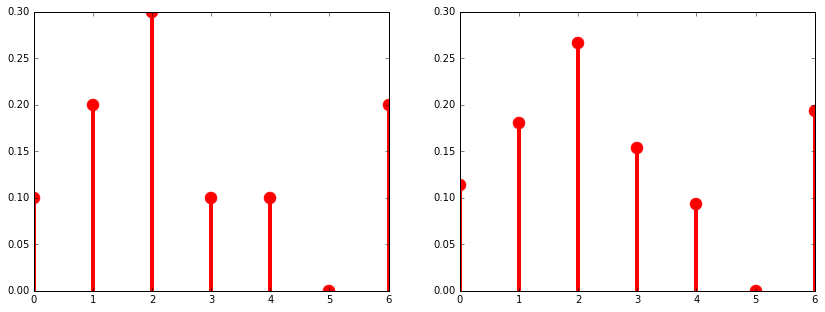

In [4]:
xk = np.arange(7)
pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)
custm = stats.rv_discrete(name='custm', values=(xk, pk))

R = custm.rvs(size=150)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax0.plot(xk, custm.pmf(xk), 'ro', ms=12, mec='r')
ax0.vlines(xk, 0,custm.pmf(xk), colors='r', lw=4)


hist, bins = np.histogram(R, len(xk), density=True)
weights = hist/np.sum(hist)
print(weights)


pk = hist/np.sum(hist)
xk = np.arange(np.amin(xk), np.amax(xk)+1)
paddingdist = stats.rv_discrete(name='Padding Distribution', values=(xk, pk))
ax1.plot(xk, paddingdist.pmf(xk), 'ro', ms=12, mec='r')
ax1.vlines(xk, 0,paddingdist.pmf(xk), colors='r', lw=4)



## Generate some padding samples with a real signal

In [5]:
# load samples, which should be padded with a
samples, samplerate = sf.read('./../res/testing/original_test_files/SQAM/64.wav', dtype=np.int16)
# use only one channel
samples = samples[:,0]
print(len(samples))

1367100


In [6]:
# %load -s generate_padding ./core/audio_cwe/catmap_encryption.py
def generate_padding(plain_samples, block_size):
    padding_length = block_size*block_size - len(plain_samples)

    bincount = (-1*(np.amin(plain_samples)))
    bincount += (np.amax(plain_samples)+1) # add the zero bin
    hist, bins = np.histogram(plain_samples, bincount, density=True)
    xk = np.arange(np.amin(plain_samples), np.amax(plain_samples)+1)

    pk = hist/np.sum(hist) # if bin width = 1


    sampdist = stats.rv_discrete(name='Sample Distribution', values=(xk, pk))
    randsamples = sampdist.rvs(size=padding_length)

    return randsamples


In [7]:
# %load -s calc_block_size ./core/audio_cwe/catmap_encryption.py
def calc_block_size(plain_samples):
    block_size = math.sqrt(len(plain_samples))

    if block_size%1>0:
        block_size += 1

    block_size = math.floor(block_size)

    return block_size


In [8]:
def print_amplitude(sampFreq, samples):
    plot(timeArray, samples, color='k')
    ylabel('Amplitude')
    xlabel('Time (ms)')

In [9]:
# generate the minimum necessary amount of pseudo random padding
padding = generate_padding(samples, calc_block_size(samples)+5) #  enlarge padding for illustration
print(len(padding), " padding samples generated")

13525  padding samples generated


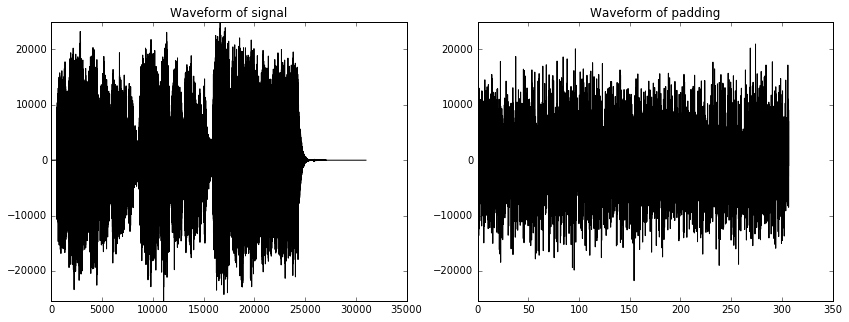

In [10]:
# plot the waveforms of signal and padding
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

timeArray = np.arange(0, len(samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

ax0.set_ylim([np.amin(samples), np.amax(samples)+1])
ax0.plot(timeArray, samples, color='k')
ax0.set_title("Waveform of signal")
timeArray = np.arange(0, len(padding), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

ax1.set_ylim([np.amin(samples), np.amax(samples)+1])
ax1.plot(timeArray, padding ,color='k') 
ax1.set_title("Waveform of padding") 
plt.show()

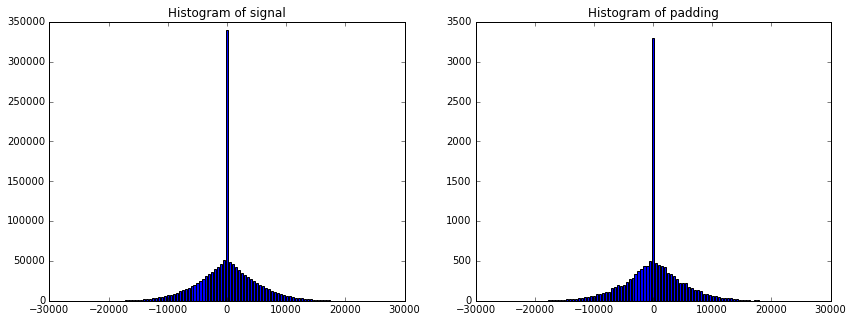

In [11]:
# Plot the histograms of signal and padding
histMin = np.amin(samples)
histMax = np.amax(samples)

hist0, bins0 = np.histogram(samples, 100, (histMin, histMax))
width0 = 0.7 * (bins0[1] - bins0[0])
center0 = (bins0[:-1] + bins0[1:]) / 2

hist1, bins1 = np.histogram(padding, 100, (histMin, histMax))
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax0.bar(center0, hist0, align='center', width=width0)
ax0.set_title("Histogram of signal")

ax1.bar(center1, hist1, align='center', width=width1)
ax1.set_title("Histogram of padding")
plt.show()

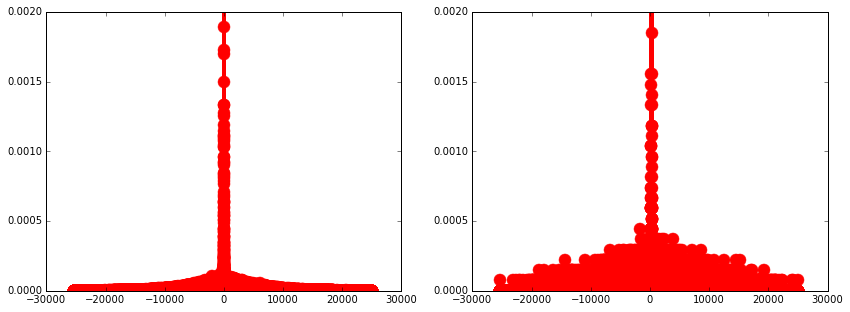

In [12]:
# Plot the discrete distributions
bincount = (-1*(np.amin(samples)))
bincount += (np.amax(samples)+1) # add the zero bin
hist, bins = np.histogram(samples, bincount, density=True)
pk = hist/np.sum(hist)
xk = np.arange(np.amin(samples), np.amax(samples)+1)
sampdist = stats.rv_discrete(name='Sample Distribution', values=(xk, pk))

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax0.plot(xk, sampdist.pmf(xk), 'ro', ms=12, mec='r')
ax0.vlines(xk, 0, sampdist.pmf(xk), colors='r', lw=4)
ax0.set_ylim(0.0, 0.002)

hist, bins = np.histogram(padding, bincount, density=True)
pk = hist/np.sum(hist)
xk = np.arange(np.amin(samples), np.amax(samples)+1)
paddingdist = stats.rv_discrete(name='Padding Distribution', values=(xk, pk))

ax1.plot(xk, paddingdist.pmf(xk), 'ro', ms=12, mec='r')
ax1.vlines(xk, 0, paddingdist.pmf(xk), colors='r', lw=4)
ax1.set_ylim(0.0, 0.002)


plt.show()